In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import os
import sys
sys.path.insert(0, os.path.dirname(os.getcwd()))

# Locations (import paths from config.py)
from config import ROOT, PATH_SPEC2VEC, PATH_MS_DATA, PATH_SAVE_MODEL, PATH_COMPUTED, PATH_OUTPUT
sys.path.insert(0, PATH_SPEC2VEC)

import helper_functions as functions
import MS_functions
from similarity_measure import SimilarityMeasures
import MS_similarity_classical as MS_sim_classic
import plotting_functions

In [2]:
file_json = os.path.join(PATH_MS_DATA, "uniqueInchikey_positive_minmax_10_1000_2dec_exp08_191116.json")
file_mgf = os.path.join(PATH_MS_DATA, "MS-MS_spectra_GNPS_cleaned_positive_mode_spectra_uniqueInchikey_subset.mgf")

spectra, spectra_dict, MS_documents, MS_documents_intensity, sub_spectra_metadata = MS_functions.load_MGF_data(file_mgf = file_mgf,
                                                           file_json = file_json,
                                                           num_decimals = 2,
                                                           min_frag = 0.0, max_frag = 1000.0,
                                                           min_loss = 5.0, max_loss = 500.0,
                                                           min_intensity_perc = 0.0,
                                                           exp_intensity_filter = 0.8,
                                                           min_keep_peaks_0 = 10,
                                                           min_keep_peaks_per_mz = 20/200,
                                                           min_peaks = 10,
                                                           max_peaks = 1000, #None, #500,
                                                           peak_loss_words = ['peak_', 'loss_'])

Spectra json file found and loaded.


In [3]:
print("Number of imported spectra:", len(spectra))

Number of imported spectra: 10998


In [4]:
MS_library = SimilarityMeasures(MS_documents, MS_documents_intensity)
MS_library.preprocess_documents(1, min_frequency = 2, create_stopwords = False)
print("Number of unique words: ", len(MS_library.dictionary))

Preprocess documents...
Number of unique words:  116344


In [5]:
file_model_word2vec = os.path.join(PATH_SAVE_MODEL, 'S2V_uniqueInchikey_pos_d300_w500_neg5_minmax10_1000_dec2_exp08_iter15.model')
MS_library.build_model_word2vec(file_model_word2vec, sg=0, negative=5, size=300, window=500, 
                             min_count=1, workers=4, iterations= [15], 
                             use_stored_model=True)

Load stored word2vec model ...


## Load Spec2Vec similarity scores

In [6]:
M_sim_ctr = np.load(os.path.join(PATH_COMPUTED, 'M_sim_spec2vec_uniqueInchikeys.npy'))

## Load similarities based on molecular fingerprints

In [7]:
filename = os.path.join(PATH_COMPUTED, 'M_sim_mol_uniqueInchikey_rdkit2048_jaccard.npy')
M_mol_sim_rdkit = MS_sim_classic.mol_sim_matrix([],
                                                [],
                                                method = 'jaccard',
                                                filename = filename)

Molecular similarity scores found and loaded.


In [8]:
M_mol_sim_rdkit.shape

(10998, 10998)

In [9]:
# pass on IDs for which fingerprint could not be calculated:
exclude_IDs = [1435, 1440, 2232, 2233, 9384, 10791, 10991]

## Load modified cosine similarities

In [10]:
filename = PATH_COMPUTED + 'M_sim_modcos_uniqueInchikey_modcos_200217_tol0005.npy'
modcos_sim_greedy, modcos_matches_greedy = MS_sim_classic.cosine_score_matrix(spectra, 
                  tol = 0.005,
                  max_mz = 1000.0, 
                  min_intens = 0,
                  mass_shifting = True,
                  method='greedy-numba', 
                  num_workers = 4,
                  filename = filename,
                  safety_points = 20)

Complete cosine similarity scores found and loaded.


In [11]:
min_match = 6
M_sim_modcos = modcos_sim_greedy * (modcos_matches_greedy > min_match)

del modcos_sim_greedy, modcos_matches_greedy

## Load cosine similarities

In [12]:
filename = PATH_COMPUTED + 'M_sim_cosine_uniqueInchikey_cosine_200217_tol0005.npy'
cosine_sim_greedy, cosine_matches_greedy = MS_sim_classic.cosine_score_matrix(spectra, 
                  tol = 0.005,
                  max_mz = 1000.0, 
                  min_intens = 0,
                  mass_shifting = False, #set to True for modified cosine score
                  method='greedy-numba', 
                  num_workers = 4,
                  filename = filename,
                  safety_points = 20)

Complete cosine similarity scores found and loaded.


In [13]:
min_match = 6
M_sim_cosine = cosine_sim_greedy * (cosine_matches_greedy > min_match)

del cosine_sim_greedy, cosine_matches_greedy

# Query the different similariy matrices
## Example for: cosine=low, molnet=low, word2vec=high, molecular similarity=high

In [14]:
pair_selection = np.where((M_sim_cosine < 0.3)
                          & (M_sim_modcos < 0.3)
                          & (M_sim_modcos > 0)
                & (M_sim_ctr > 0.85) 
                & (M_sim_ctr < 0.98) 
                & (M_mol_sim_rdkit > 0.8))

print("Found ", pair_selection[0].shape, " matching spectral pairs.")

Found  (3294,)  matching spectral pairs.


In [15]:
from plotting_functions import plot_spectra_comparison

In [42]:
from MS_functions import create_MS_documents
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import SVG, display
from scour import scour

def plot_spectra_comparison(MS_measure,
                            spectra,
                            num_decimals,
                            ID1, ID2,
                            min_mz = 5,
                            max_mz = 500,
                            threshold = 0.01,
                            tol = 0.5,
                            method = 'cosine',
                            wordsim_cutoff = 0.5,
                            circle_size = 5,
                            circle_scaling = 'wordsim', 
                            padding = 10,
                            display_molecules = False,
                            figsize=(12, 12),
                            filename = None):
    """ In-depth visual comparison of spectral similarity scores,
    calculated based on cosine/mod.cosine and Spev2Vec.

    Args:
    --------
    method: str
        'cosine' or 'modcos' (modified cosine score)
    circle_scaling: str
        Scale circles based on 'wordsim' or 'peak_product'
    """
    plt.style.use('ggplot')

    from scipy import spatial
    plot_colors = ['darkcyan', 'purple']

    # Definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.005

    rect_wordsim = [left, bottom, width, height]
    rect_specx = [left, bottom + height + spacing, width, 0.2]
    rect_specy = [left + width, bottom, 0.2, height]

    peaks1 = np.array(spectra[ID1].peaks.copy())
    peaks2 = np.array(spectra[ID2].peaks.copy())
    peaks1[:,1] = peaks1[:,1]/np.max(peaks1[:,1])
    peaks2[:,1] = peaks2[:,1]/np.max(peaks2[:,1])

    # Sort by m/z to be in line with word order in MS_documents
    peaks1 = peaks1[np.lexsort((peaks1[:,1], peaks1[:,0])),:]
    peaks2 = peaks2[np.lexsort((peaks2[:,1], peaks2[:,0])),:]

    # Remove peaks lower than threshold
    select1 = np.where((peaks1[:,1] > threshold) & (peaks1[:,0] <= max_mz) & (peaks1[:,0] >= min_mz))[0]
    select2 = np.where((peaks2[:,1] > threshold) & (peaks2[:,0] <= max_mz) & (peaks2[:,0] >= min_mz))[0]

    # TODO: only include sub-function to create documents...
    dictionary = [MS_measure.dictionary[x] for x in MS_measure.dictionary]
    MS_documents, MS_documents_intensity, _ = create_MS_documents([spectra[x] for x in [ID1,ID2]],
                                                                 num_decimals = num_decimals,
                                                                 peak_loss_words = ['peak_', 'loss_'],
                                                                 min_loss = 0,
                                                                 max_loss = max_mz,
                                                                 ignore_losses = True)

    # Remove words/peaks that are not in dictionary
    select1 = np.array([x for x in select1 if MS_documents[0][x] in dictionary])
    select2 = np.array([x for x in select2 if MS_documents[1][x] in dictionary])

    peaks1 = peaks1[select1, :]
    peaks2 = peaks2[select2, :]
    min_peaks1 = np.min(peaks1[:,0])
    min_peaks2 = np.min(peaks2[:,0])
    max_peaks1 = np.max(peaks1[:,0])
    max_peaks2 = np.max(peaks2[:,0])

    word_vectors1 = MS_measure.model_word2vec.wv[[MS_documents[0][x] for x in select1]]
    word_vectors2 = MS_measure.model_word2vec.wv[[MS_documents[1][x] for x in select2]]

    Csim_words = 1 - spatial.distance.cdist(word_vectors1, word_vectors2, 'cosine')
    Csim_words[Csim_words < wordsim_cutoff] = 0  # Remove values below cutoff
    print(np.min(Csim_words))

    # Plot spectra
    # -------------------------------------------------------------------------
    fig = plt.figure(figsize=figsize)
    # Word similariy plot (central)
    ax_wordsim = plt.axes(rect_wordsim)
    ax_wordsim.tick_params(direction='in', top=True, right=True)
    # Spectra plot (top)
    ax_specx = plt.axes(rect_specx)
    ax_specx.tick_params(direction='in', labelbottom=False)
    # Spectra plo 2 (right)
    ax_specy = plt.axes(rect_specy)
    ax_specy.tick_params(direction='in', labelleft=False)

    # Spec2Vec similarity plot:
    # -------------------------------------------------------------------------
    data_x = []
    data_y = []
    data_z = []
    data_peak_product = []
    for i in range(len(select1)):
        for j in range(len(select2)):
            data_x.append(peaks1[i,0])
            data_y.append(peaks2[j,0])
            data_z.append(Csim_words[i,j])
            data_peak_product.append(peaks1[i,1]*peaks2[j,1])

    # Sort by word similarity
    data_x = np.array(data_x)
    data_y = np.array(data_y)
    data_z = np.array(data_z)
    data_peak_product = np.array(data_peak_product)
    idx = np.lexsort((data_x, data_y, data_z))


    cm = plt.cm.get_cmap('RdYlBu_r') #'YlOrRd') #'RdBu_r')

    # Plot word similarities
    if circle_scaling == 'peak_product':
        wordsimplot = ax_wordsim.scatter(data_x[idx], data_y[idx],
                           s = 100 * circle_size * (0.01 + data_peak_product[idx]),
                           c= data_z[idx], cmap=cm, alpha=0.6)
    elif circle_scaling == 'wordsim':
        wordsimplot = ax_wordsim.scatter(data_x[idx], data_y[idx],
                           s = 100 * circle_size * (0.01 + data_z[idx]**2),
                           c= data_z[idx], cmap=cm, alpha=0.6)


    # (modified) Cosine similarity plot:
    # -------------------------------------------------------------------------
    if method == 'cosine':
        shift = 0
    elif method == 'modcos':
        shift = spectra[ID1].parent_mz - spectra[ID2].parent_mz
    else:
        print("Given method unkown.")

    _, used_matches = MS_sim_classic.cosine_score_greedy(peaks1,
                                                         peaks2,
                                                         mass_shift = shift,
                                                         tol = 0.005,
                                                         min_intens = 0,
                                                         use_numba = True)

    idx1, idx2, _ = zip(*used_matches)
    cosine_x = []
    cosine_y = []
    for i in range(len(idx1)):
        cosine_x.append(peaks1[idx1[i],0])
        cosine_y.append(peaks2[idx2[i],0])

    # Plot (mod.) cosine similarities
    ax_wordsim.scatter(cosine_x, cosine_y, s= 100, c = 'black', marker=(5, 2))
    ax_wordsim.set_xlim(min_peaks1-padding, max_peaks1+padding)
    ax_wordsim.set_ylim(min_peaks2-padding, max_peaks2+padding)
    ax_wordsim.set_xlabel('spectra 1 - fragment mz', fontsize=16)
    ax_wordsim.set_ylabel('spectra 2 - fragment mz', fontsize=16)
    ax_wordsim.tick_params(labelsize=13)

    # Plot spectra 1
    ax_specx.vlines(peaks1[:,0], [0], peaks1[:,1], color=plot_colors[0])
    ax_specx.plot(peaks1[:,0], peaks1[:,1], '.')  # Stem ends
    ax_specx.plot([peaks1[:,0].max(), peaks1[:,0].min()], [0, 0],  '--')  # Middle bar
    ax_specx.set_xlim(min_peaks1-padding, max_peaks1+padding)
    ax_specx.set_ylabel('peak intensity (relative)', fontsize=16)
    ax_specx.tick_params(labelsize=13)

    # Plot spectra 2
    ax_specy.hlines(peaks2[:,0], [0], peaks2[:,1], color=plot_colors[1])
    ax_specy.plot(peaks2[:,1], peaks2[:,0], '.')  # Stem ends
    ax_specy.plot([0, 0], [peaks2[:,0].min(), peaks2[:,0].max()], '--')  # Middle bar
    ax_specy.set_ylim(min_peaks2-padding, max_peaks2+padding)
    ax_specy.set_xlabel('peak intensity (relative)', fontsize=16)
    ax_specy.tick_params(labelsize=13)

    fig.colorbar(wordsimplot, ax=ax_specy)
    if filename is not None:
        plt.savefig(filename)
    plt.show()

    # Plot molecules
    # -------------------------------------------------------------------------
    if display_molecules:
        smiles = []
        for i, candidate_id in enumerate([ID1, ID2]):
            smiles.append(spectra[candidate_id].metadata["smiles"])

        if filename is not None:
            plot_molecules(smiles,
                          filename = filename[:-4] + '_molecules')
        else:
            plot_molecules(smiles)

    return Csim_words

def Scour(target, source, env=[]):
    """ Use scour to clean an svg file.

    """
    options = scour.generateDefaultOptions()

    ## override defaults for max cleansing
    options.enable_viewboxing = True
    options.strip_comments = True
    options.strip_ids = True
    options.remove_metadata = True
    options.indent_type = None
    options.shorten_ids = True

    if 'SCOUR_OPTIONS' in env:
        options.__dict__.update(env['SCOUR_OPTIONS'])

    if False:
        from pprint import pprint
        print("\nUsing Scour options:\n")
        pprint(options.__dict__)

    instream = open(source, 'rb')
    outstream = open(target, 'wb')

    scour.start(options, instream, outstream)


def plot_molecules(smiles_lst,
                  filename = None):
    """ Plot molecule from smile(s).
    Uses Scour to clean rdkit svg.

    filename: str
        If filename is given, molecules will be saved to filename.
    """
    if not isinstance(smiles_lst, list):
        smiles_lst = [smiles_lst]
    for i, smiles in enumerate(smiles_lst):
        temp_file = "draw_mols_temp.svg"
        mol = Chem.MolFromSmiles(smiles)
        Draw.MolToFile(mol, temp_file)

        # Clean svg using scour
        if filename is not None:
            file = filename.split('.svg')[0] + str(i) + '.svg'
        else:
            file = "draw_mols_temp_corr.svg"
        Scour(file, temp_file , [])

        # Display cleaned svg
        display(SVG(filename=temp_file))

8682 8681
Spec2Vec score:  0.8841032784256807
Cosine score:  0.0
Modified cosine score:  0.01840308374623471
Molecular similarity:  0.8867562380038387
  Created documents for  2  of  2  spectra.0.0


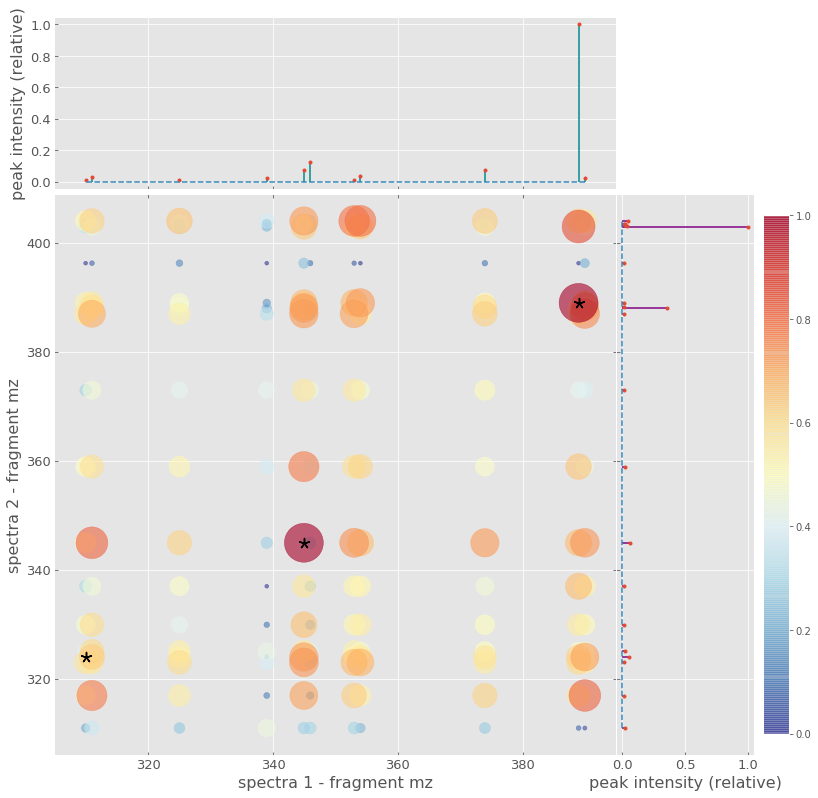

Scour processed file "draw_mols_temp.svg" in 50 ms: 8307/13614 bytes new/orig -> 61.0%


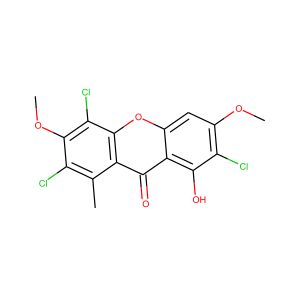

Scour processed file "draw_mols_temp.svg" in 47 ms: 8275/13694 bytes new/orig -> 60.4%


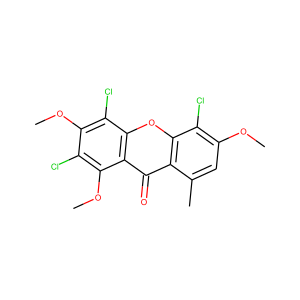

In [45]:
#similar cases: 10,11, 15, 20, 100, 500...
# other usually large molecule types: 200, 800, 1000, 1700, 2000, 2600, 3280
# smaller molecules: 2996, 2007, 3000, 3003, 3004, 3005, 3010
# Long chains: 3200, 3230 

id = 3011
ID1, ID2 = pair_selection[0][id], pair_selection[1][id]
print(ID1, ID2)
print("Spec2Vec score: ", M_sim_ctr[ID1, ID2])
print("Cosine score: ", M_sim_cosine[ID1, ID2])
print("Modified cosine score: ", M_sim_modcos[ID1, ID2])
print("Molecular similarity: ", M_mol_sim_rdkit[ID1, ID2])

Csim_words = plot_spectra_comparison(MS_library,
                                      spectra,
                                      2,
                                      ID1, ID2, 
                                      min_mz = 300, 
                                      max_mz = 800,
                                      threshold = 0.01,
                                      tol = 0.005,
                                      method = 'modcos',
                                      wordsim_cutoff = 0, #-1
                                      circle_size = 15,
                                      circle_scaling = 'wordsim',
                                      padding = 5,
                                      display_molecules = True)

303 291
Spec2Vec score:  0.9576214004700782
Cosine score:  0.055420545697188184
Modified cosine score:  0.06902653436065635
Molecular similarity:  0.8700284090909091
  Created documents for  2  of  2  spectra.0.0


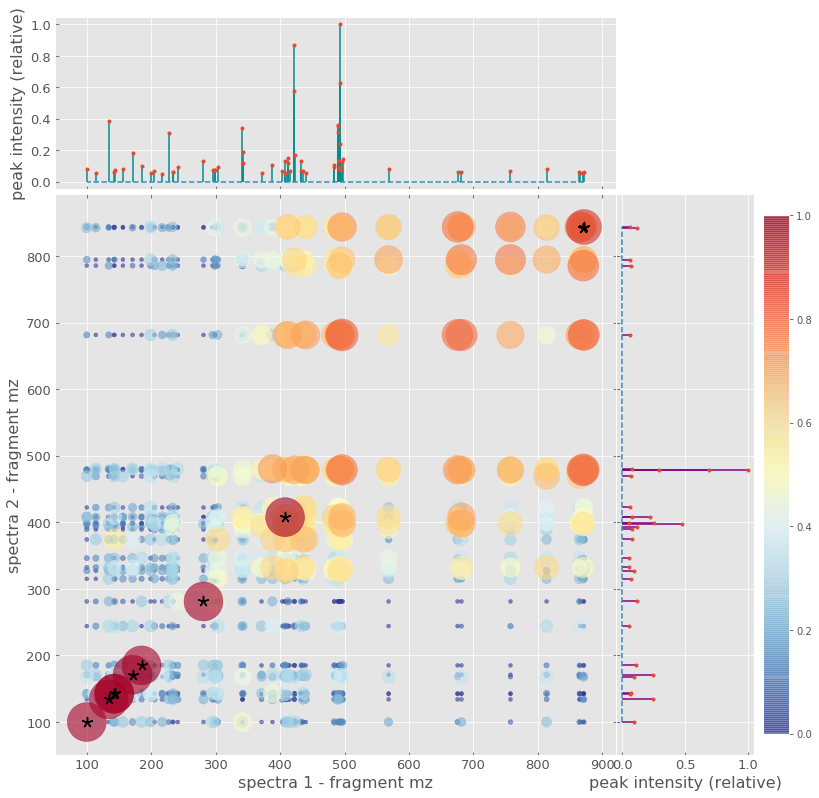

Scour processed file "draw_mols_temp.svg" in 161 ms: 17801/31123 bytes new/orig -> 57.2%


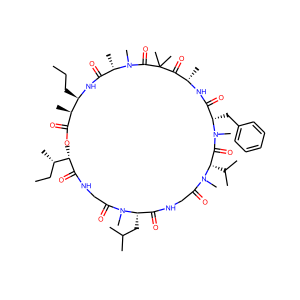

Scour processed file "draw_mols_temp.svg" in 107 ms: 17659/30923 bytes new/orig -> 57.1%


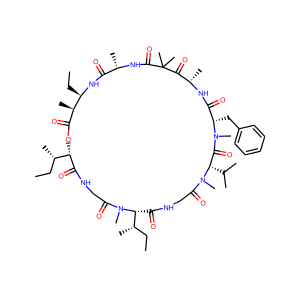

In [46]:
#similar cases: 10,11, 15, 20, 100, 500...
# other usually large molecule types: 200, 800, 1000, 1700, 2000, 2600, 3280
# smaller molecules: 2996, 2007, 3000, 3003, 3004, 3005, 3010
# Long chains: 3200, 3230 

id = 100
ID1, ID2 = pair_selection[0][id], pair_selection[1][id]
print(ID1, ID2)
print("Spec2Vec score: ", M_sim_ctr[ID1, ID2])
print("Cosine score: ", M_sim_cosine[ID1, ID2])
print("Modified cosine score: ", M_sim_modcos[ID1, ID2])
print("Molecular similarity: ", M_mol_sim_rdkit[ID1, ID2])

Csim_words = plot_spectra_comparison(MS_library,
                                      spectra,
                                      2,
                                      ID1, ID2, 
                                      min_mz = 0, 
                                      max_mz = 1000,
                                      threshold = 0.05,
                                      tol = 0.005,
                                      method = 'modcos',
                                      wordsim_cutoff = 0, #-1
                                      circle_size = 15,
                                      circle_scaling = 'wordsim',
                                      padding = 50, 
                                      display_molecules = True,
                                      filename = 'in_depth_example.pdf')



303 291
Spec2Vec score:  0.9576214004700782
Cosine score:  0.055420545697188184
Modified cosine score:  0.06902653436065635
Molecular similarity:  0.8700284090909091
  Created documents for  2  of  2  spectra.0.0


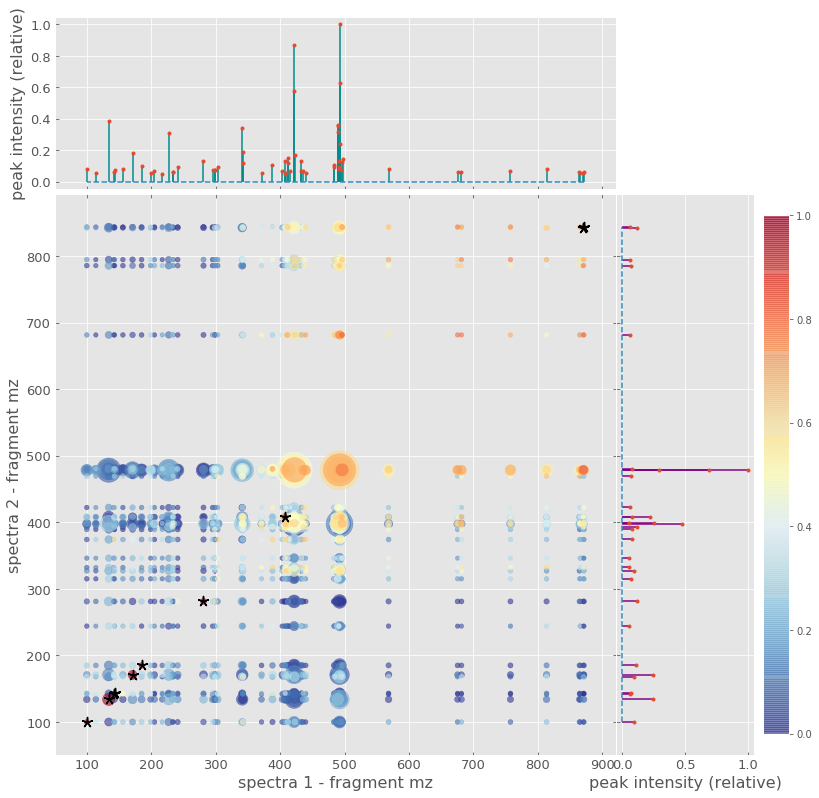

Scour processed file "draw_mols_temp.svg" in 113 ms: 17801/31123 bytes new/orig -> 57.2%


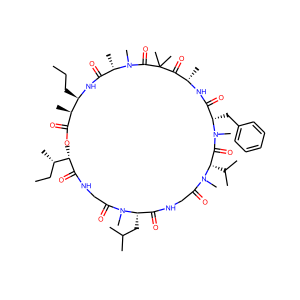

Scour processed file "draw_mols_temp.svg" in 87 ms: 17659/30923 bytes new/orig -> 57.1%


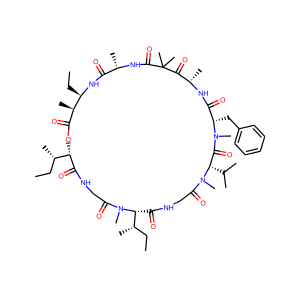

In [44]:
#similar cases: 10,11, 15, 20, 100, 500...
# other usually large molecule types: 200, 800, 1000, 1700, 2000, 2600, 3280
# smaller molecules: 2996, 2007, 3000, 3003, 3004, 3005, 3010
# Long chains: 3200, 3230 

id = 100
ID1, ID2 = pair_selection[0][id], pair_selection[1][id]
print(ID1, ID2)
print("Spec2Vec score: ", M_sim_ctr[ID1, ID2])
print("Cosine score: ", M_sim_cosine[ID1, ID2])
print("Modified cosine score: ", M_sim_modcos[ID1, ID2])
print("Molecular similarity: ", M_mol_sim_rdkit[ID1, ID2])

Csim_words = plot_spectra_comparison(MS_library,
                                      spectra,
                                      2,
                                      ID1, ID2, 
                                      min_mz = 0, 
                                      max_mz = 1000,
                                      threshold = 0.05,
                                      tol = 0.005,
                                      method = 'modcos',
                                      wordsim_cutoff = 0, #-1
                                      circle_size = 15,
                                      circle_scaling = 'peak_product',
                                      padding = 50, 
                                      display_molecules = True,
                                      filename = 'in_depth_example.pdf')



# Case 2:
## Example for: cosine=high, molnet=high, word2vec=low, molecular similarity=low

In [18]:
pair_selection2 = np.where((M_sim_cosine > 0.8)
                          & (M_sim_modcos >  0.9)
                & (M_sim_ctr < 0.3)  
                & (M_mol_sim_rdkit < 0.3))

print("Found ", pair_selection2[0].shape, " matching spectral pairs.")

Found  (276,)  matching spectral pairs.


6890 4875
Spec2Vec score:  0.17875768261521663
Cosine score:  0.9177690585341765
Modified cosine score:  0.9177690585341765
Molecular similarity:  0.27347611202635913
  Created documents for  2  of  2  spectra.0.0


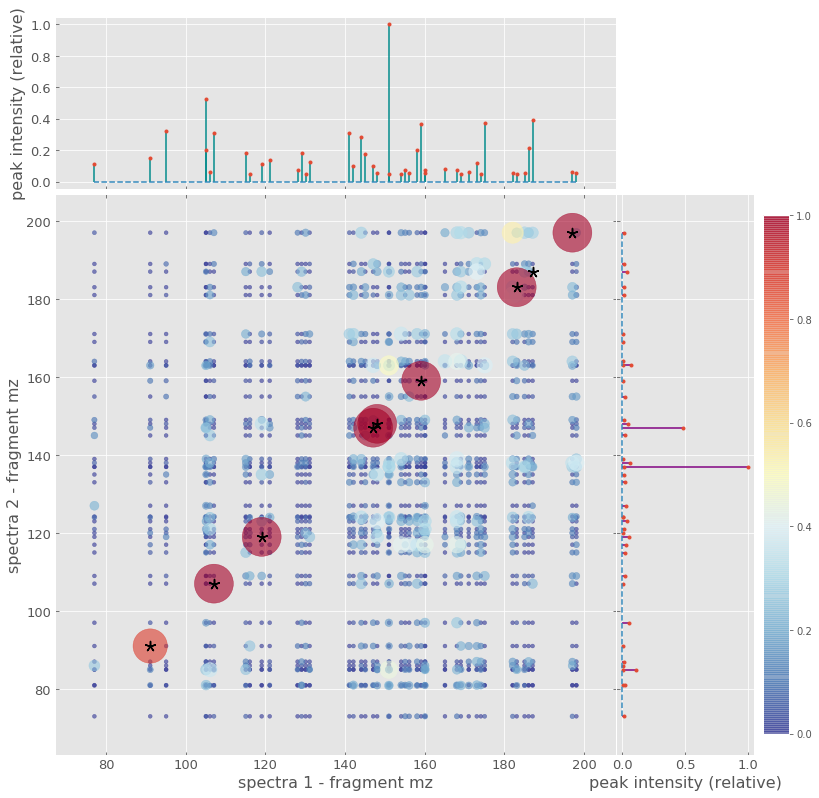

Scour processed file "draw_mols_temp.svg" in 27 ms: 5813/9803 bytes new/orig -> 59.3%


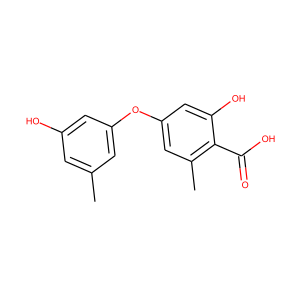

Scour processed file "draw_mols_temp.svg" in 50 ms: 10368/17656 bytes new/orig -> 58.7%


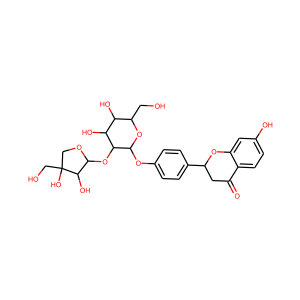

In [22]:
id = 200 #40, 200
ID1, ID2 = pair_selection2[0][id], pair_selection2[1][id]
print(ID1, ID2)
print("Spec2Vec score: ", M_sim_ctr[ID1, ID2])
print("Cosine score: ", M_sim_cosine[ID1, ID2])
print("Modified cosine score: ", M_sim_modcos[ID1, ID2])
print("Molecular similarity: ", M_mol_sim_rdkit[ID1, ID2])

Csim_words = plot_spectra_comparison(MS_library,
                                      spectra,
                                      2,
                                      ID1, ID2, 
                                      min_mz = 0, 
                                      max_mz = 200,
                                      threshold = 0.001,
                                      tol = 0.005,
                                      method = 'modcos',
                                      wordsim_cutoff = 0, #-1
                                      circle_size = 15,
                                      padding = 10, 
                                      display_molecules = True)

# Case 3:
## Example for: cosine=low, molnet=high, word2vec=low, molecular similarity=low

In [24]:
pair_selection3 = np.where((M_sim_cosine < 0.3)
                          & (M_sim_modcos >  0.9)
                & (M_sim_ctr < 0.3)  
                & (M_mol_sim_rdkit < 0.3))

print("Found ", pair_selection2[0].shape, " matching spectral pairs.")

Found  (13330,)  matching spectral pairs.


2587 8278
Spec2Vec score:  0.006342231232695061
Cosine score:  0.0
Modified cosine score:  0.9245496598411368
Molecular similarity:  0.20493827160493827
  Created documents for  2  of  2  spectra.0.0


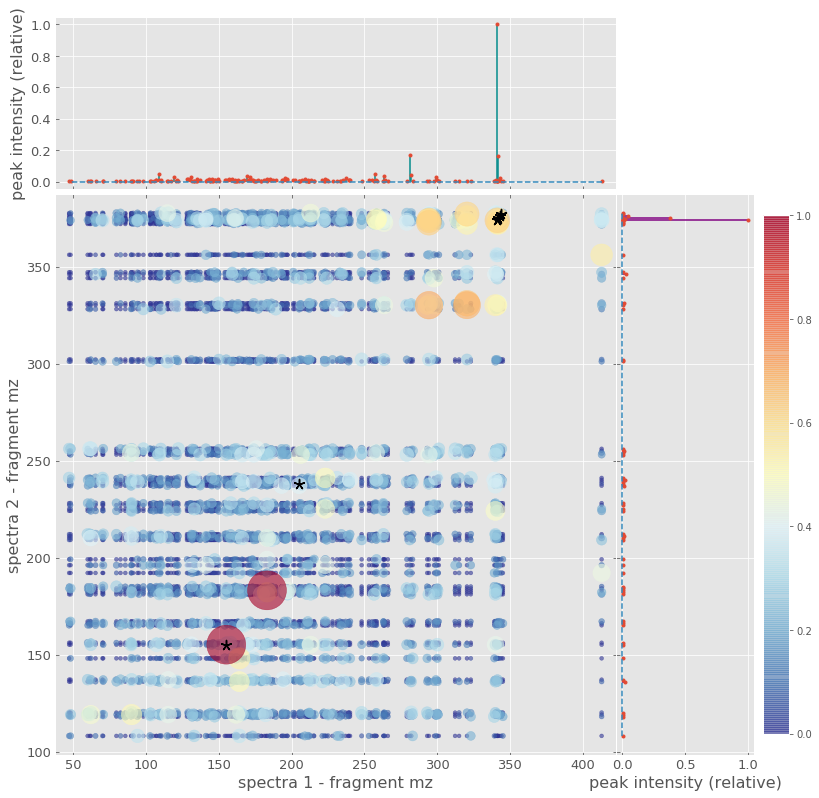

Scour processed file "draw_mols_temp.svg" in 32 ms: 6316/11022 bytes new/orig -> 57.3%


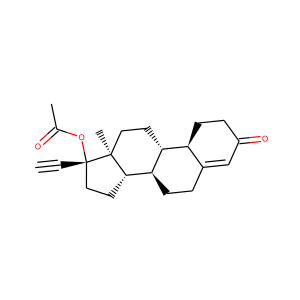

Scour processed file "draw_mols_temp.svg" in 49 ms: 8285/14201 bytes new/orig -> 58.3%


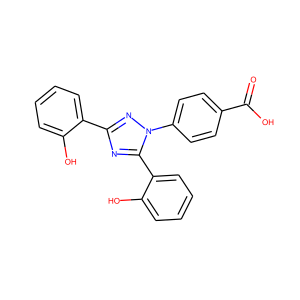

In [33]:
id = 5000
ID1, ID2 = pair_selection3[0][id], pair_selection3[1][id]
print(ID1, ID2)
print("Spec2Vec score: ", M_sim_ctr[ID1, ID2])
print("Cosine score: ", M_sim_cosine[ID1, ID2])
print("Modified cosine score: ", M_sim_modcos[ID1, ID2])
print("Molecular similarity: ", M_mol_sim_rdkit[ID1, ID2])

Csim_words = plot_spectra_comparison(MS_library,
                                      spectra,
                                      2,
                                      ID1, ID2, 
                                      min_mz = 0, 
                                      max_mz = 1000,
                                      threshold = 0.001,
                                      tol = 0.005,
                                      method = 'modcos',
                                      wordsim_cutoff = 0, #-1
                                      circle_size = 15,
                                      padding = 10, 
                                      display_molecules = True)